In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# 数据获取及预处理
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        print(self.train_data.shape)
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        print(self.train_data.shape)
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, np.shape(self.train_data)[0], batch_size)
        return self.train_data[index, :], self.train_label[index]

In [3]:
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            padding='same',         # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 32]
        x = self.pool1(x)                       # [batch_size, 14, 14, 32]
        x = self.conv2(x)                       # [batch_size, 14, 14, 64]
        x = self.pool2(x)                       # [batch_size, 7, 7, 64]
        x = self.flatten(x)                     # [batch_size, 7 * 7 * 64]
        x = self.dense1(x)                      # [batch_size, 1024]
        x = self.dense2(x)                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

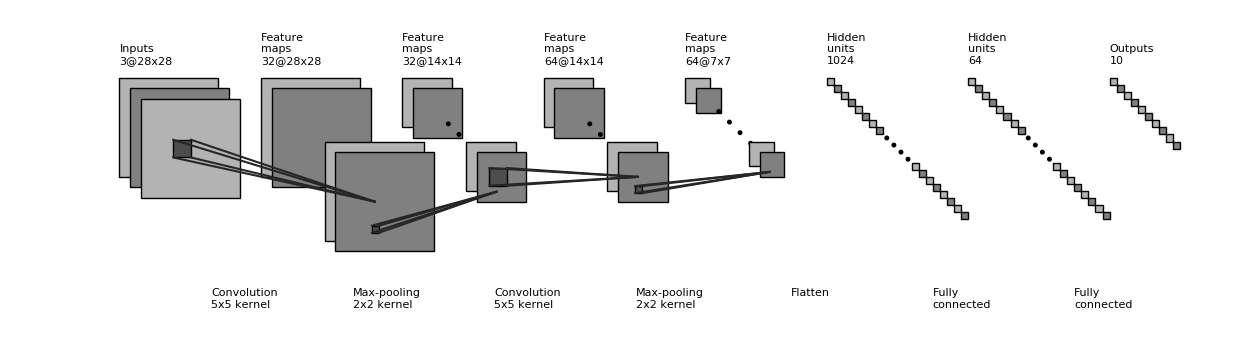

In [4]:
num_epochs = 1
batch_size = 100
learning_rate = 0.001

model = CNN()
data_loader = MNISTLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

(60000, 28, 28)
(60000, 28, 28, 1)


In [5]:
num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
num_batches = 100
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

batch 0: loss 2.305186
batch 1: loss 2.186102
batch 2: loss 1.997078
batch 3: loss 1.785988
batch 4: loss 1.520869
batch 5: loss 1.399475
batch 6: loss 1.367261
batch 7: loss 0.902328
batch 8: loss 1.103418
batch 9: loss 0.812113
batch 10: loss 0.738886
batch 11: loss 0.623466
batch 12: loss 0.581523
batch 13: loss 0.657492
batch 14: loss 0.654877
batch 15: loss 0.558466
batch 16: loss 0.580239
batch 17: loss 0.450005
batch 18: loss 0.406764
batch 19: loss 0.396476
batch 20: loss 0.567159
batch 21: loss 0.422853
batch 22: loss 0.404283
batch 23: loss 0.294134
batch 24: loss 0.401353
batch 25: loss 0.223266
batch 26: loss 0.300422
batch 27: loss 0.359299
batch 28: loss 0.325258
batch 29: loss 0.362191
batch 30: loss 0.216717
batch 31: loss 0.193499
batch 32: loss 0.213276
batch 33: loss 0.297857
batch 34: loss 0.328735
batch 35: loss 0.290675
batch 36: loss 0.136759
batch 37: loss 0.224409
batch 38: loss 0.200907
batch 39: loss 0.207922
batch 40: loss 0.224911
batch 41: loss 0.244727
ba

In [6]:
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

test accuracy: 0.967500
